#### CV Libraries
* torchvision
* torchvision.datasets
* torchvision.models
* torchvision.transforms

In [1]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

/Users/lorenzo/Documents/repos/learning/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using: {device}")
SEED = 42
torch.manual_seed(SEED)

Using: cpu


In [3]:
DATA_DIR = 'data/'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [4]:
# get dataset fashion MNIST for testing
train_data = datasets.FashionMNIST(root=DATA_DIR,
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root=DATA_DIR,
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
# classes
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# classes to index
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
image, label = train_data[0]
image.shape # Color channel, H x W

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

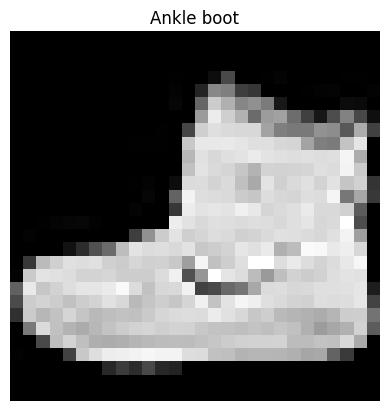

In [10]:
# visualize first image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(classes[label])
plt.axis(False)

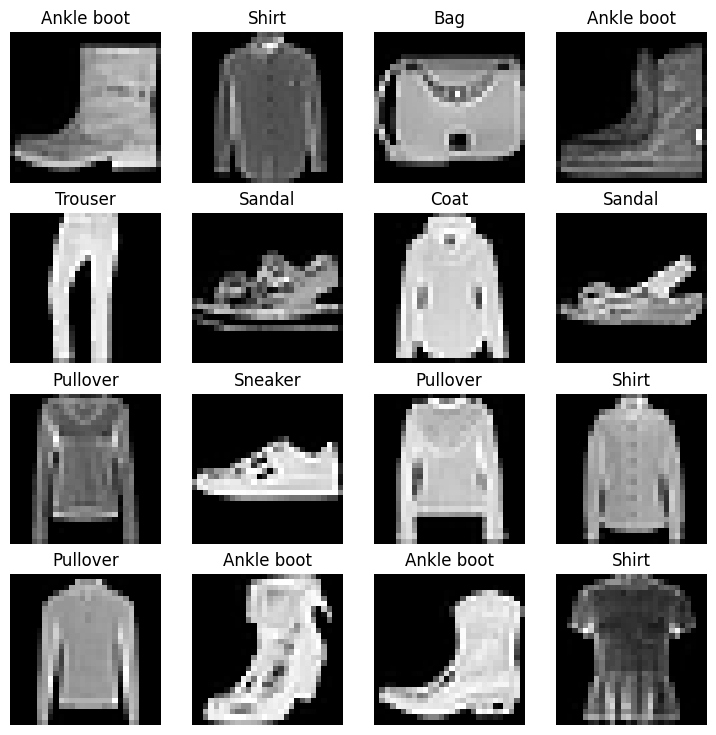

In [11]:
# visualize more imgs
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(classes[label])
    plt.axis(False)

In [12]:
from torch.utils.data import DataLoader

# turn data into batches
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [13]:
print(f'There are {len(train_dataloader)} batches for train and {len(test_dataloader)} for test')

There are 1875 batches for train and 313 for test


In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

### Baseline Model - Linear

In [15]:
# flatten layer
flatten_model = nn.Flatten()

x = train_features_batch[0]
print(f"Shape of x: {x.shape}")

# forward pass inside flatten
output = flatten_model(x)

print(f"Shape after flattening: {output.shape}")

Shape of x: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [16]:
class CVFashionModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):

        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [17]:
model_0 = CVFashionModelV0(input_shape=28*28, hidden_units=16, output_shape=len(classes)).to(device)
model_0

CVFashionModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [18]:
# loss, accuracy and optim setup
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [19]:
from timeit import default_timer as timer

# timing helper function
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

#### Train Loop

In [20]:
from tqdm.auto import tqdm

st = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    # init loss per batch
    train_loss = 0
    # batch loop
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # forward pass
        y_pred = model_0(X)
        # loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # optim zero grad
        optim.zero_grad()
        # backprop
        loss.backward()
        # optim step
        optim.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
    # average train_loss per epoch    
    train_loss /= len(train_dataloader)
    
    # test loop
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

et = timer()
time_model_0 = print_train_time(start=st, end=et, device=device)

  0%|                                                                                                                           | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|██████████████████████████████████████▎                                                                            | 1/3 [00:07<00:15,  7.70s/it]


Train loss: 0.5835 | Test loss: 0.5069, Test acc: 81.98%
Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 2/3 [00:15<00:07,  7.62s/it]


Train loss: 0.4732 | Test loss: 0.4717, Test acc: 83.01%
Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.63s/it]


Train loss: 0.4525 | Test loss: 0.4710, Test acc: 83.49%
Train time on cpu: 22.895 seconds


#### Evaluate

In [21]:
def eval_model(model: torch.nn.Module,
               data: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn, 
               device=device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data)
        acc /= len(data)
    
    return {'model_name': model.__class__.__name__,
            'model_loss': round(loss.item(), 4),
            'model_acc': round(acc, 2)}

In [22]:
model_0_res = eval_model(model=model_0,
                         data=test_dataloader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn)
model_0_res

{'model_name': 'CVFashionModelV0', 'model_loss': 0.471, 'model_acc': 83.49}

### Model 1 - Non-Linear

In [23]:
class CVFashionModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
        
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [24]:
model_1 = CVFashionModelV1(input_shape=28*28, hidden_units=16, output_shape=len(classes)).to(device)
model_1

CVFashionModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [25]:
# loss, acc and optim setup
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [26]:
def train_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              optim: torch.optim.Optimizer,
              acc,
              data: torch.utils.data.DataLoader,
              device: torch.device = device):
    
    model.train()
    
    # init loss per batch
    train_loss, train_acc = 0, 0
    # batch loop
    for batch, (X, y) in enumerate(data):
        X, y = X.to(device), y.to(device)
        # forward pass
        y_pred = model(X)
        # loss and acc per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc(y_true=y, y_pred=y_pred.argmax(dim=1))
        # optim zero grad
        optim.zero_grad()
        # backprop
        loss.backward()
        # optim step
        optim.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(data.dataset)} samples")
        
    # average train_loss and train_acc per epoch    
    train_loss /= len(data)
    train_acc /= len(data)
    
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [27]:
def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              acc,
              data: torch.utils.data.DataLoader,
              device: torch.device = device):

    model.eval()
    
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += acc(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(data)
        test_acc /= len(data)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

#### Train

In [28]:
st = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------------")

    train_step(model=model_1,
               data=train_dataloader,
               loss_fn=loss_fn,
               optim=optim,
               acc=accuracy_fn)
    
    test_step(model=model_1,
              data=test_dataloader,
              loss_fn=loss_fn,
              acc=accuracy_fn)
    
et = timer()
train_time_model_1 = print_train_time(start=st, end=et, device=device)

  0%|                                                                                                                           | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 1.12417 | Train acc: 59.57%


 33%|██████████████████████████████████████▎                                                                            | 1/3 [00:07<00:15,  7.77s/it]

Test loss: 0.92811 | Test acc: 65.92%
Epoch: 1
-----------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.80098 | Train acc: 70.72%


 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 2/3 [00:15<00:07,  7.73s/it]

Test loss: 0.69788 | Test acc: 74.12%
Epoch: 2
-----------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.46560 | Train acc: 83.38%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.75s/it]

Test loss: 0.44469 | Test acc: 84.38%
Train time on cpu: 23.269 seconds


#### Eval

In [29]:
model_1_res = eval_model(model=model_1,
                         data=test_dataloader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn)
model_1_res

{'model_name': 'CVFashionModelV1', 'model_loss': 0.4447, 'model_acc': 84.38}

### Model 2 - CNN

In [30]:
class CVFashionModelV2(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # square size
                      stride=1,      # default value
                      padding=1),    # no padding or same padding (output has same shape as input)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)   # default stride value is same as kernel_size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        # print(f'shape after block 1 {x.shape}')
        x = self.block_2(x)
        # print(f'shape after block 2 {x.shape}')
        x = self.classifier(x)
        # print(f'shape afterclassifier {x.shape}')
        return x
    
model_2 = CVFashionModelV2(input_shape=1, hidden_units=10,
                           output_shape=len(classes)).to(device)
model_2

CVFashionModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [31]:
# testing init
images = torch.randn(size=(32, 3, 64, 64)) # [batch size, color channels, H, W]
test_image = images[0]
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


In [32]:
# testing layers
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [33]:
# there is a shape mismatch error above, we need to add a dim
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [34]:
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [35]:
# test different kernel size
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [36]:
# testing MaxPool (compressing data)
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

# shapes get halved

Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [37]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

#### Train

In [38]:
st = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------------")
    
    train_step(model=model_2,
               data=train_dataloader,
               loss_fn=loss_fn,
               optim=optim,
               acc=accuracy_fn)
    
    test_step(model=model_2,
              data=test_dataloader,
              loss_fn=loss_fn,
              acc=accuracy_fn)
    
et = timer()
train_time_model_2 = print_train_time(start=st, end=et, device=device)

  0%|                                                                                                                           | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.54370 | Train acc: 80.29%


 33%|██████████████████████████████████████▎                                                                            | 1/3 [00:38<01:17, 38.76s/it]

Test loss: 0.37820 | Test acc: 86.86%
Epoch: 1
-----------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.35050 | Train acc: 87.27%


 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 2/3 [01:21<00:41, 41.15s/it]

Test loss: 0.34361 | Test acc: 87.80%
Epoch: 2
-----------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.31521 | Train acc: 88.66%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.43s/it]

Test loss: 0.34324 | Test acc: 87.70%
Train time on cpu: 124.284 seconds


#### Eval

In [39]:
model_2_res = eval_model(model=model_2,
                         data=test_dataloader,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn)
model_2_res

{'model_name': 'CVFashionModelV2', 'model_loss': 0.3432, 'model_acc': 87.7}

### Compare Models

In [40]:
import pandas as pd

In [41]:
compare = pd.DataFrame([model_0_res, model_1_res, model_2_res])
compare['train_time'] = [time_model_0, train_time_model_1, train_time_model_2]
compare

,model_name,model_loss,model_acc,train_time
0,CVFashionModelV0,0.4710,83.49,22.895247
1,CVFashionModelV1,0.4447,84.38,23.269018
2,CVFashionModelV2,0.3432,87.70,124.284181


Text(0, 0.5, 'model')

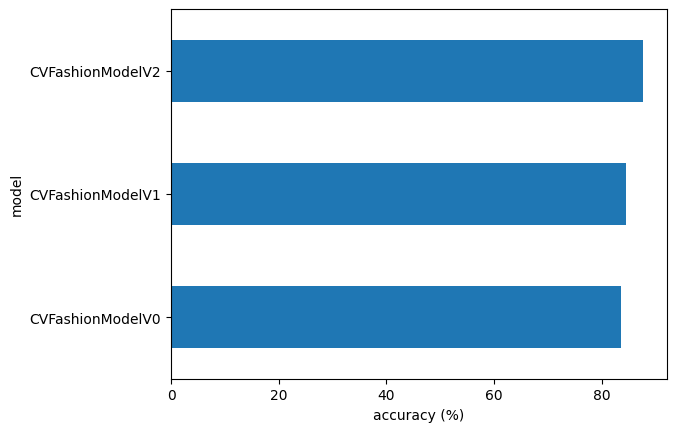

In [42]:
# visualize
compare.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')

### Predictions

In [43]:
def make_pred(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # add extra dimension at pos 0
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # forward pass
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [44]:
# prepare samples
import random
random.seed(SEED)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [45]:
# make predictions
pred_probs = make_pred(model=model_2, data=test_samples)

# from probs to labels
pred_classes = pred_probs.argmax(dim=1)

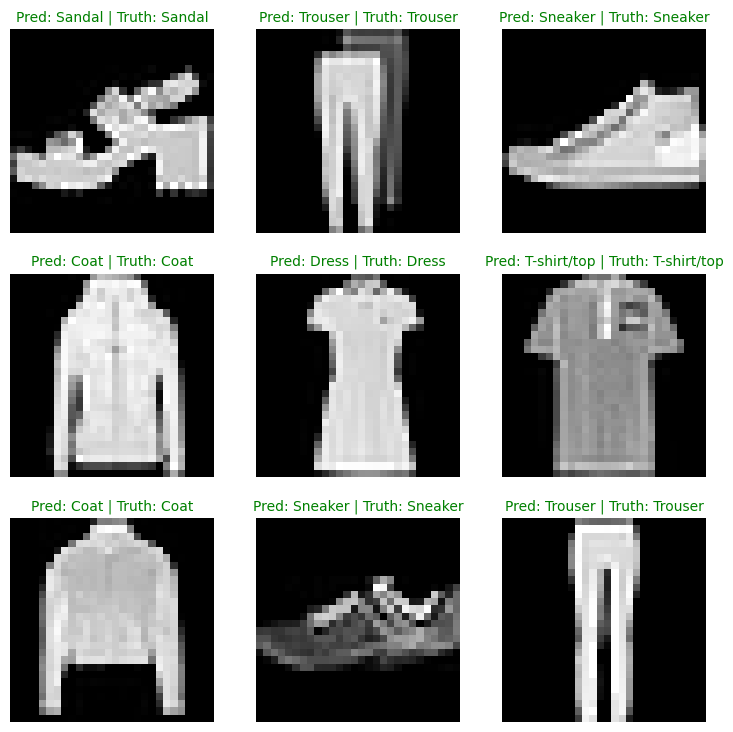

In [46]:
# visualize
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # subplot
    plt.subplot(nrows, ncols, i+1)

    # target image
    plt.imshow(sample.squeeze(), cmap='gray')

    # prediction label (in text form)
    pred_label = classes[pred_classes[i]]

    # true label (in text form, e.g. "T-shirt")
    true_label = classes[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {true_label}"
  
    # Check for equality and change title colour accordingly
    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

#### Confusion Matrix

In [47]:
# making predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions'):
        X, y = X.to(device), y.to(device)
        # forward pass
        y_logit = model_2(X)
        # logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.21it/s]


In [48]:
# see if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0


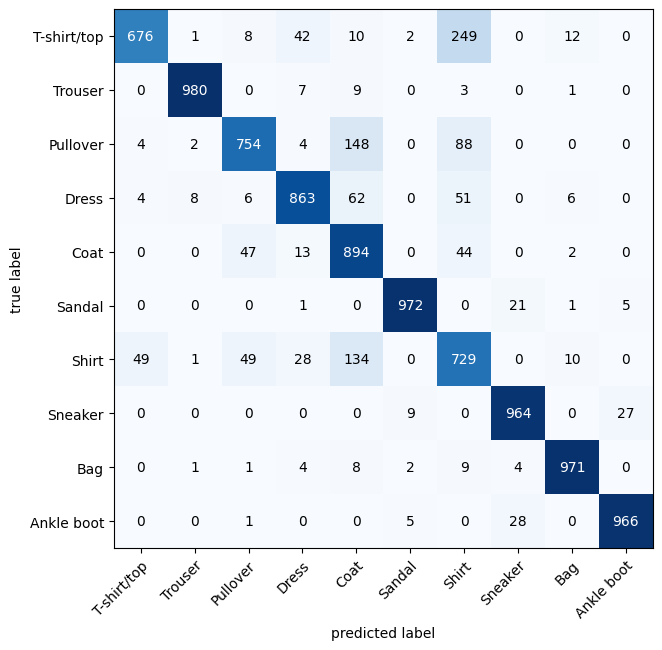

In [49]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# plot
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7)
)

### Save

In [50]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_NAME = '03_computer_vision_2.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_computer_vision_2.pth
